Compare the errors for the two taggers: Logistic Regression and the LLM-based with structured output on
the hard sentences list of sentences that have 1 to 3 errors each (we ignore sentences that have many more
errors as these cases are probably caused by a complete break-down of the expectations of the tagger).

Compute the same statistics reported for the Logistic Regression Tagger in the notebook for the LLM
Tagger (token-level metric).

In [1]:
import pyconll, nltk, datetime, warnings, os, json, copy
import numpy as np
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
from numpy.random import seed

Plot Functions:

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

Gather data created with ud_pos_tagger_gemini.py

In [19]:
with open("test_hard_sentences_gemini.json", "r") as f:
    task = json.load(f)

task_sentences = [[tuple(pair) for pair in sentence] for sentence in task]
hard_sentences = []
fixed_errors = []
new_errors = []
error_analysis = []
for j in range(len(task_sentences)):
    errors=0 
    stat_tokens=0 
    stat_pred_fail=0
    for i in range(len(task_sentences[j][0])):
        
        token = task_sentences[j][0][i][0]
        tag = task_sentences[j][0][i][1]
        pred_tag = task_sentences[j][1][i][1]
        gemini_tag = "ERROR"
        if len(task_sentences[j]) > 2 and i<len(task_sentences[j][2]) and task_sentences[j][2][i][0] == token:
            stat_tokens+=1
            gemini_tag = task_sentences[j][2][i][1]
            if tag!=gemini_tag: errors+=1
            if tag!=pred_tag: stat_pred_fail+=1
            if tag!=pred_tag and tag==gemini_tag: fixed_errors.append((token, task_sentences[j][0], task_sentences[j][1], task_sentences[j][2]))
            if tag!=gemini_tag and tag==pred_tag: new_errors.append((token, task_sentences[j][0], task_sentences[j][1], task_sentences[j][2]))
    
    if errors >=1: hard_sentences.append((task_sentences[j][0], errors, task_sentences[j][2]))
    if errors >=3 and len(error_analysis) < 30 : error_analysis.append((task_sentences[j][0], errors, task_sentences[j][2]))

Histogram of hard sentences:

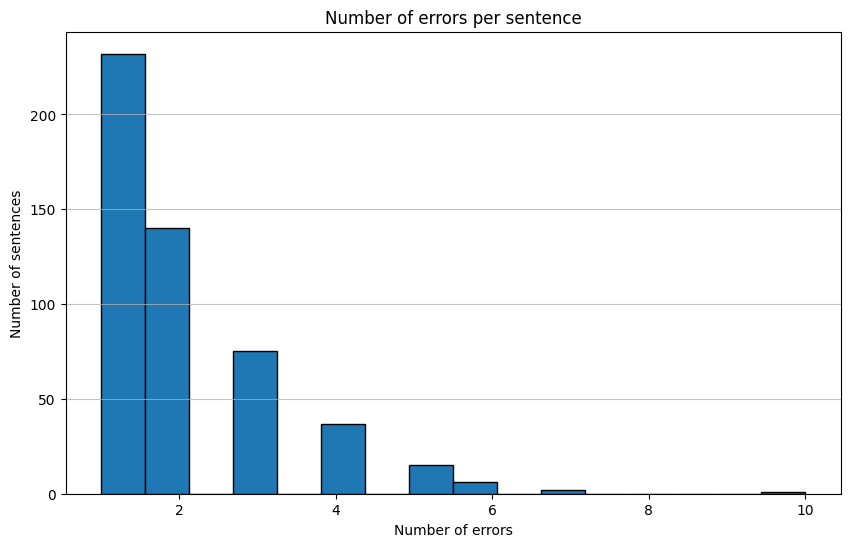

In [11]:
# Draw a histogram of the number of errors per sentence
plt.figure(figsize=(10, 6))
plt.hist([x[1] for x in hard_sentences], bins=16, edgecolor='black')
plt.title('Number of errors per sentence')
plt.xlabel('Number of errors')
plt.ylabel('Number of sentences')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [18]:
print(f"num of logistic regression errors fixed by the LLM:{len(fixed_errors)}\nnum of new errors made by the LLM:{len(new_errors)}")
print(f"success rate of logistic regression on hard sentences:{(stat_tokens-stat_pred_fail) / stat_tokens}\nsuccess rate of gemini on hard sentences:{(stat_tokens-errors)/ stat_tokens}")

num of logistic regression errors fixed by the LLM:543
num of new errors made by the LLM:603
success rate of logistic regression on hard sentences:0.8888888888888888
success rate of gemini on hard sentences:0.9444444444444444


Based on the statistics, Gemini LLM fails the most on adjectives, classifying them as nouns, proper nouns or verbs.
The following two sentences have adjectives that could be interpreted as nouns or verbs:
"She saw the fallen rest quietly."
"Only the bold thrive here."

In [23]:

#import pydantic
from pydantic import BaseModel
class ErrorAnalysis(BaseModel):
    """Represents a token , its correct and predicted tags and an explanation of the error and error category."""
    word: str #Annotated[str, Field(desription="The word/token in the sentence.")]
    correct_tag: str #Annotated[str, Field(description="The correct part-of-speech tag for the token.")]
    predicted_tag: str #Annotated[str , Field(description="The predicted part-of-speech tag for the token.")]
    explanation: str #Annotated[str , Field(description="A one paragraph explanation of why this mismatch might occur in tagging this token within this sentence")]
    category: str #Annotated[str , Field(description="Error category, to be used for further analysis of most common error categories")]


with open("error_analysis.json", "r") as f:
    task23 = json.load(f)

error_analysis = [ErrorAnalysis(**item) for item in task23]
categories = []
for ea in error_analysis:
    print(ea.explanation)
    if ea.category not in categories: categories.append(ea.category)

for c in categories:
    print(c)



The word 'my' is a possessive determiner acting as an auxiliary verb, but the tagger misidentified it as a pronoun.
The word 'to' is a particle, but the tagger did not mis-tag this instance.
The word 'be' functions as an auxiliary verb in this sentence, but the tagger incorrectly tagged it as a main verb.
The word 'Military' is a noun, but the tagger incorrectly tagged it as a proper noun. This could be due to the context of the sentence which is about the US military.
The tagger correctly identified the word as a particle.
The word 'which' is a relative pronoun introducing a clause, but the tagger misidentified it as a determiner.
The word 'about' is a preposition, but the tagger incorrectly tagged it as an adverb.
The word 'Government' is a noun, but the tagger incorrectly tagged it as a proper noun. This could be due to the context of the sentence which is about a government.
The word "magazine" is used here as a proper noun, referring to a specific publication. The tagger incorrect

I really need better prompts, this data is useless.